# Setup

In [13]:
%%capture
%pip show transformers
%pip show accelerate
%pip install transformers[torch] -U
%pip install accelerate -U
%pip install transformers
%pip install pytorch-lightning
%pip install --upgrade transformers
%pip install datasets

# Preprocessing

In [ ]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
from transformers import TrainingArguments
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import os
import gdown


# 1. Prepare Dataset
# 2. Load pretrained Tokenizer, call it with dataset -> encoding
# 3. Build PyTorth Dataset with encodings
# 4. Load pretrained Model
# 5. Load HF Trainer and train it

file_id = '1E5v6t-y2Pzeyi5C-amlYibp2cXUN0MLW'
url = f'https://drive.google.com/uc?id={file_id}'
file_path = 'all_data.csv'
if not os.path.exists(file_path):
    # Download the file
    gdown.download(url, file_path, quiet=False)

# Read the csv file
all_data = pd.read_csv(file_path, engine='python')

from sklearn.model_selection import train_test_split
toxicity_train_df, toxicity_test_df = train_test_split(all_data, test_size=0.40, random_state=42)

# List of categories to check
categories_to_check = ['obscene', 'sexual_explicit', 'threat', 'insult', 'identity_attack']

toxicity_train_df[categories_to_check] = toxicity_train_df[categories_to_check].apply(pd.to_numeric, errors='coerce')
toxicity_test_df[categories_to_check] = toxicity_test_df[categories_to_check].apply(pd.to_numeric, errors='coerce')

# Check if any category is above the 0.33 threshold
toxicity_train_df['toxic'] = (toxicity_train_df[categories_to_check] >= 0.33).any(axis=1).astype(float)
toxicity_test_df['toxic'] = (toxicity_test_df[categories_to_check] >= 0.33).any(axis=1).astype(float)

# Convert boolean values to 1.0 for True and 0.0 for False
toxicity_train_df['toxic'] = toxicity_train_df['toxic'].astype(float)
toxicity_test_df['toxic'] = toxicity_test_df['toxic'].astype(float)

toxicity_train_df = toxicity_train_df[['comment_text', 'toxic', 'obscene', 'sexual_explicit', 'threat', 'insult', 'identity_attack']]
toxicity_test_df = toxicity_test_df[['comment_text', 'toxic', 'obscene', 'sexual_explicit', 'threat', 'insult', 'identity_attack']]

# Can be adjusted to downsample training data
sample_rate = 1.0

toxicity_train_df = toxicity_train_df.sample(frac=sample_rate, random_state=42)

print("Toxic train examples")
print(toxicity_train_df.head(4))

print("Toxic test examples")
print(toxicity_test_df.head(4))

Toxic train examples
                                              comment_text  toxic  obscene  \
680779   I commented on this last week on the Kiszla st...    0.0      0.0   
465571   We should store all illegals in truck bodies t...    1.0      0.0   
1710822  You're beginning to sound like Saddam's spokes...    0.0      0.0   
1727503  Weird comment. If the environmentalists caused...    0.0      0.0   

         sexual_explicit   threat    insult  identity_attack  
680779               0.0  0.00000  0.000000           0.0000  
465571               0.0  0.21875  0.140625           0.4375  
1710822              0.0  0.00000  0.200000           0.0000  
1727503              0.0  0.00000  0.000000           0.0000  
Toxic test examples
                                              comment_text  toxic  obscene  \
1610665  Naturally you can feel it in your urine. \nTha...    0.0      0.0   
495126   Yum!  What's not to love: water+maple syrup - ...    0.0      0.0   
431396   Catou I wi

Test Lengths of DFs

In [8]:
print(len(toxicity_train_df))
# print(len(toxicity_test_df))


1199709


# Visualization of toxicity in train

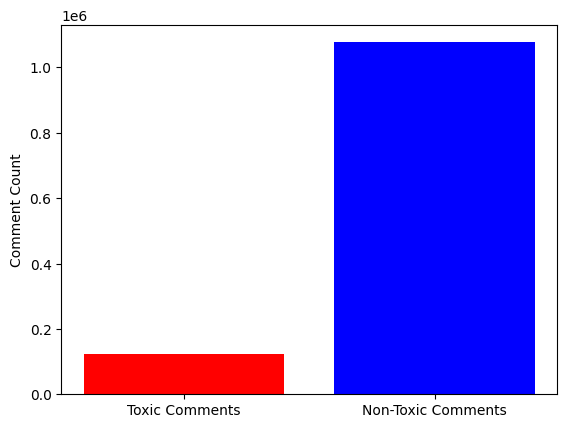

In [9]:
# Count toxic and non-toxic comments
toxic_count = toxicity_train_df['toxic'].sum()
non_toxic_count = len(toxicity_train_df) - toxic_count

# Plot side-by-side bars for toxic and non-toxic comments
labels = ['Toxic Comments', 'Non-Toxic Comments']
counts = [toxic_count, non_toxic_count]

plt.bar(labels, counts, color=['red', 'blue'])
plt.ylabel('Comment Count')

plt.show()

# Visualization of toxicity in test

In [10]:
# # Count toxic and non-toxic comments
# toxic_count = toxicity_test_df['toxic'].sum()
# non_toxic_count = len(toxicity_test_df) - toxic_count

# # Plot side-by-side bars for toxic and non-toxic comments
# labels = ['Toxic Comments', 'Non-Toxic Comments']
# counts = [toxic_count, non_toxic_count]

# plt.bar(labels, counts, color=['red', 'blue'])
# plt.ylabel('Comment Count')

# plt.show()

# Splitting and Labelling

In [11]:
model_name = "roberta-base"

# Reset index to ensure consistency
toxicity_train_df.reset_index(drop=True, inplace=True)
# toxicity_test_df.reset_index(drop=True, inplace=True)

# Select relevant columns from DataFrame and drop NaN values
train_data = toxicity_train_df[['comment_text', 'toxic']].dropna()
# test_data = toxicity_test_df[['comment_text', 'toxic']].dropna()

# Extract features and labels
train_texts = train_data['comment_text'].tolist()
train_labels = train_data['toxic'].tolist()
# test_texts = test_data['comment_text'].tolist()
# test_labels = test_data['toxic'].tolist()

# Print examples of texts & labels
print("train_texts:")
print(train_texts[:5])
print("train_labels:")
print(train_labels[:5])
# print("test_texts")
# print(test_texts[:5])
# print("test_labels:")
# print(test_labels[:5])

# Split train data into train and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=0.2)


train_texts:
["I commented on this last week on the Kiszla story of Dennison going to be a factor. Not only was he a factor, but the refs and home field was something Denver didn't handle well at all. The games aren't fixed but the refs are instructed to keep things close I am certain. Winning on the road is something that takes discipline and focus. They'll learn but it sucks to watch it happen.", 'We should store all illegals in truck bodies then ask them if they are ready to return to Mexico.', "You're beginning to sound like Saddam's spokesman Chemical Ali...", 'Weird comment. If the environmentalists caused the contaminations you might have a point.', 'canadian patriot writes:\n\n"KGB bloggers are sure trying hard to make Pukin a silk purse from a sow\'s ear. \n\nEven a face lift and elevator shoes cannot hide a Slav thug."\n\nAnd Naddaway gives patriot\'s post a "Disagree" vote.\n\nNaddaway postulates that a face lift and elevator shoes can, indeed, after all, hide a slavic thug.

# Dataset

In [12]:
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaModel


class ToxicDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx]).float()
        return item

    def __len__(self):
        return len(self.labels)

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
# test_encodings = tokenizer(test_texts, truncation=True, padding=True)

train_dataset = ToxicDataset(train_encodings, train_labels)
val_dataset = ToxicDataset(val_encodings, val_labels)
# test_dataset = ToxicDataset(test_encodings, test_labels)

print("Train Dataset")
# Iterate over train_dataset and print some samples
for i in range(2):  # Print first 2 samples
    sample = train_dataset[i]
    print(f"Sample {i + 1}:")
    # Convert input_ids tensor to list and access its keys
    encoding_keys = tokenizer.convert_ids_to_tokens(sample["input_ids"].tolist())
    print("Encoding keys:", encoding_keys)  # Print keys of encoding
    print("Label:", sample["labels"].item())  # Print label
    print()

print("Val Dataset")
# Iterate over val dataset and print some samples
for i in range(2):  # Print first 2 samples
    sample = val_dataset[i]
    print(f"Sample {i + 1}:")
    # Convert input_ids tensor to list and access its keys
    encoding_keys = tokenizer.convert_ids_to_tokens(sample["input_ids"].tolist())
    print("Encoding keys:", encoding_keys)  # Print keys of encoding
    print("Label:", sample["labels"].item())  # Print label
    print()

print("Test Dataset")
# Iterate over test dataset and print some samples
for i in range(2):  # Print first 2 samples
    # sample = test_dataset[i]
    # print(f"Sample {i + 1}:")
    # Convert input_ids tensor to list and access its keys
    encoding_keys = tokenizer.convert_ids_to_tokens(sample["input_ids"].tolist())
    print("Encoding keys:", encoding_keys)  # Print keys of encoding
    print("Label:", sample["labels"].item())  # Print label
    print()

KeyboardInterrupt: 

# Native PyTorch (instead of HF Trainer)

In [ ]:
from torch.utils.data import DataLoader
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup
import torch
import random

# Set random seed for reproducability
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

# Access GPU or CPU depending on status
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Grab generic roberta-base model to be fine tuned
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=1)
model.to(device)
model.train()

# Initialize training params
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
optim = AdamW(model.parameters(), lr=1e-5)
num_train_epochs = 1

# Total number of training steps
total_steps = len(train_loader) * num_train_epochs

# Create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optim, num_warmup_steps=0, num_training_steps=total_steps)

# Fine-tuned roberta-base model
for epoch in range(num_train_epochs):
  total_loss = 0.0
  for batch_idx, batch in enumerate(train_loader):
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['labels'].to(device)

      outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

      loss = outputs[0]  # No normalization by gradient_accumulation_steps
      total_loss += loss.item()

      loss.backward()

      # Perform an optimization step after every batch
      optim.step()

      # Update the learning rate
      scheduler.step()

      optim.zero_grad()

      if (batch_idx + 1) % 1 == 0:  # Print progress every 50 batches
          print(f"Epoch [{epoch + 1}/{num_train_epochs}], Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {total_loss / (batch_idx + 1):.4f}")

  print(f"Epoch [{epoch + 1}/{num_train_epochs}], Average Loss: {total_loss / len(train_loader):.4f}")

model.eval()

# Store the fine-tuned model for later use
model.save_pretrained('usr/fine_tuned_roberta_RETRAINED')


Download file paths (if desired)

Sometimes can alter the json file and cause the subsequent code cells to fail. Hence, commented out for now.

In [ ]:
# from google.colab import files

# # Paste the path you copied as the argument to files.download()

# from tqdm import tqdm
# from google.colab import files

# # File paths to download
# file_paths = ['/usr/fine_tuned_roberta_model_2/config.json', '/usr/fine_tuned_roberta_model_2/model.safetensors']

# # Loop through each file and download with tqdm progress bar
# for file_path in file_paths:
#     with open(file_path, 'wb') as f:
#         with tqdm(unit='B', unit_scale=True, unit_divisor=1024, miniters=1,
#                   desc=file_path.split('/')[-1]) as pbar:
#             # Download the file
#             files.download(file_path)
#             # Manually update progress bar
#             pbar.update()

# Default RoBERTa test as baseline

In [ ]:
import pandas as pd
import numpy as np
from transformers import RobertaTokenizer, AutoModelForSequenceClassification
import torch
import random

# Set a fixed state for randomness
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

# Load the tokenizer and model for inference
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = AutoModelForSequenceClassification.from_pretrained('roberta-base')


# Move the model to CPU if it's on CUDA device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Put the model in evaluation mode
model.eval()

# Function to convert LABEL_0 to 'no'
def convert_label(prediction):
    return 'no' if prediction[0]['label'] == 'LABEL_0' else 'yes'

global count
count = 0

def predict_label(row):
    global count
    text_to_predict = row['comment_text']

    encoding = tokenizer(text_to_predict, return_tensors='pt', padding=True, truncation=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    probabilities = torch.sigmoid(logits).cpu().numpy().flatten()
    binary_label = 1 if ((np.abs(probabilities[1] - probabilities[0]) <= 0.061) and (probabilities[0] < 0.5425)) else 0
    count = count + 1
    if (count % 1000 == 0):
      print(count)
    if(count < 10):
      # Print out some examples of stream comments and their respective probabilities and label (toxic/non-toxic)
      print(text_to_predict)
      print(probabilities)
      # The difference in probabilities represents a confidence interval which is also important to evaluate
      print(np.abs(probabilities[1] - probabilities[0]))
      print(binary_label)
    return binary_label

# Load the Twitch dataset
twitch_df = pd.read_csv('hasanAbiTest.csv')
print(len(twitch_df))

# Apply the prediction function to each row in the DataFrame
twitch_df['base_prediction'] = twitch_df.apply(predict_label, axis=1)

# Assuming 'LABEL_0' corresponds to 'no'
prediction_counts = twitch_df['base_prediction'].value_counts()
print(prediction_counts)

# Print the counts
print("Count of 'no':", prediction_counts[0.0])
print("Count of 'yes':", prediction_counts[1.0])  # Adjust the label if needed

# Base Toxic Word Cloud

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import nltk
import pandas as pd
import string

# Download NLTK resources (run only once)
nltk.download('stopwords')
nltk.download('punkt')

print(twitch_df.info())

# Filter toxic comments
toxic_comments = twitch_df[twitch_df['base_prediction'] == 1]['comment']
print(toxic_comments.head(5))

# Initialize NLTK stop words
stop_words = set(stopwords.words('english'))

# Extend the stop words list with additional common words to exclude
additional_stop_words = ['today', "don't", 'like', 'know', 'and', 'the',
                         'get', 'HasanAbi', 'hasanabi', 'Hasan', 'hasan', 'Abi',
                         'dont', ',', 'got', 'cant', 'make',
                         'see', 'im', 'make', 'think', 'one', 'every',
                         'take', 'day', 'really', 'Tier', 'tier', 'Tier 1',
                         '1', 'Theyve', 'theyve', 'going', 'subscribed', 'months']  # Add more words as needed
stop_words.update(additional_stop_words)

# Remove punctuation from comments
def remove_punctuation(text):
    return ''.join([char for char in text if char not in string.punctuation])

cleaned_comments = ' '.join([comment for comment in toxic_comments])
cleaned_comments = remove_punctuation(cleaned_comments)

# Tokenize the cleaned comments
tokens = nltk.word_tokenize(cleaned_comments)

# Remove stop words
tokens = [word for word in tokens if word.lower() not in stop_words]

# Calculate word frequencies
freq_dist = nltk.FreqDist(tokens)

# Generate the word cloud with frequencies
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(freq_dist)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [ ]:
!pip install better-profanity

# Fine-Tuned Roberta on Cleaned UWB Review Dataset stream dataset

In [ ]:
import pandas as pd
import numpy as np
from transformers import RobertaTokenizer, AutoModelForSequenceClassification
import torch
import random
from better_profanity import profanity

# Set a fixed state for randomness
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)  # If using CUDA

# Load the tokenizer and model for inference
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = AutoModelForSequenceClassification.from_pretrained('fine_tuned_roberta')

# Move the model to CPU if it's on CUDA device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Put the model in evaluation mode
model.eval()

# Function to convert LABEL_0 to 'no'
def convert_label(prediction):
    return 'no' if prediction[0]['label'] == 'LABEL_0' else 'yes'

def contains_profanity(text):
    return profanity_check.predict([text])[0]

global count
global sub_mention
sub_mention = False
profanity_in = False
count = 0

def predict_label(row):
    global count
    global sub_mention
    text_to_predict = row['Review-Body']
    if pd.isnull(text_to_predict):
      text_to_predict = "No Comments" 
    # Filter out mentionings of Twitch subscriptions and tiers
    sub_mention = any(keyword in text_to_predict for keyword in ["Tier 1", "subscribed with Prime", "subbed using Prime"])
    # Leverages better profanity to catch additional profanity occurences
    profanity_in = profanity.contains_profanity(text_to_predict)
    encoding = tokenizer(text_to_predict, return_tensors='pt', padding=True, truncation=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    probabilities = torch.sigmoid(logits).cpu().numpy().flatten()
    binary_label = 1 if profanity_in or (np.abs(probabilities[0]) > 0.56 and not sub_mention) else 0
    count = count + 1
    if (count % 1000 == 0):
      print(count)
    if(count < 25):
      # Print out some examples of stream comments and their respective probabilities and label (toxic/non-toxic)
      print(text_to_predict)
      print(np.abs(probabilities[0]))
      print(binary_label)
    return binary_label

# Load the Twitch dataset
twitch_df = pd.read_csv('Cleaned_UW_RMP.csv')
print(f"Total length of test: {len(twitch_df)}")

# Apply the prediction function to each row in the DataFrame
twitch_df['roberta_UWBR_prediction'] = twitch_df.apply(predict_label, axis=1)

prediction_counts = twitch_df['roberta_UWBR_prediction'].value_counts()
print(prediction_counts)

# Print the counts
print("Count of 'no':", prediction_counts[0.0])
print("Count of 'yes':", prediction_counts[1.0])

Note the ***detection of new toxic words*** not found in previous stream: Lefters, Libbers, Hoggers (assuming political connotations).

Note the ***detection of user toxicity*** such as "Yelling at Trolls", and "I'm not trolling", "CLICKBAIT".

Note the filtering out of typical Twitch platform messages subscription mentioning: "Tier 1, has subscribed, etc".

See Excel file for more details if curious.

Save Predictions for Fine-Tuned Wikipedia Model

In [ ]:
!pip install openpyxl
# Define the file path for the Excel file
excel_file_path = "/usr/roberta_cardiff_UWBR_predictions.xlsx"

# Save the 'roberta_wiki_prediction' column to an Excel file
twitch_df['roberta_UWBR_prediction'].to_excel(excel_file_path, index=False)

# Fine-Tuned Wikipedia Toxic Word Cloud

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import nltk
import pandas as pd
import string

# Download NLTK resources (run only once)
nltk.download('stopwords')
nltk.download('punkt')

# Filter toxic comments
toxic_comments = twitch_df[twitch_df['roberta_wiki_prediction'] == 1]['comment']
print(toxic_comments.head(5))

batch_size = 1000  # Set the batch size
num_rows = len(twitch_df)
with open('union_output.txt', 'w') as f:
    for start in range(0, num_rows, batch_size):
        end = min(start + batch_size, num_rows)
        for index, row in twitch_df.iloc[start:end].iterrows():
            f.write(str(row['roberta_wiki_prediction']) + '\n')

# from google.colab import files
# files.download('union_output.txt')

# Initialize NLTK stop words
stop_words = set(stopwords.words('english'))

# Extend the stop words list with additional common words to exclude
additional_stop_words = ['today', "don't", 'like', 'know', 'and', 'the',
                         'get', 'HasanAbi', 'hasanabi', 'Hasan', 'hasan', 'Abi',
                         'dont', ',', 'got', 'cant', 'make',
                         'see', 'im', 'make', 'think', 'one', 'every',
                         'take', 'day', 'really']  # Add more words as needed
stop_words.update(additional_stop_words)

# Remove punctuation from comments
def remove_punctuation(text):
    return ''.join([char for char in text if char not in string.punctuation])

cleaned_comments = ' '.join([comment for comment in toxic_comments])
cleaned_comments = remove_punctuation(cleaned_comments)

# Tokenize the cleaned comments
tokens = nltk.word_tokenize(cleaned_comments)

# Remove stop words
tokens = [word for word in tokens if word.lower() not in stop_words]

# Calculate word frequencies
freq_dist = nltk.FreqDist(tokens)

# Generate the word cloud with frequencies
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(freq_dist)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


# Preprocessing on Twitch Union dataset

In [ ]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
from transformers import Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# 1. Prepare Dataset
# 2. Load pretrained Tokenizer, call it with dataset -> encoding
# 3. Build PyTorth Dataset with encodings
# 4. Load pretrained Model
# 5. Load HF Trainer and train it

# Train Data (Roberta + Llama Union), 11449 rows
toxicity_train_df = pd.read_csv('toxic_union.csv',  on_bad_lines='skip')
toxicity_train_df = toxicity_train_df.dropna()

# Test Data - 7287 rows after pre-processing
toxicity_test_df = pd.read_csv('toxicity_test.csv', on_bad_lines='skip', quoting=csv.QUOTE_NONE)
toxicity_test_df = toxicity_test_df.dropna()

# Only check these categories in toxicity_test since train is our union csv
# built from the previous fine-tuning and training cells
categories_to_check = ['obscene', 'sexual_explicit', 'threat', 'insult', 'identity_attack']

toxicity_test_df[categories_to_check] = toxicity_test_df[categories_to_check].apply(pd.to_numeric, errors='coerce')

# Check if any category is above the 0.33 threshold
toxicity_test_df['toxic'] = (toxicity_test_df[categories_to_check] >= 0.33).any(axis=1).astype(float)
toxicity_test_df['toxic'] = toxicity_test_df['toxic'].astype(float)
toxicity_test_df = toxicity_test_df[['comment_text', 'toxic', 'obscene', 'sexual_explicit', 'threat', 'insult', 'identity_attack']]

print("Toxic train examples")
print(toxicity_train_df.head(4))

print("Toxic test examples")
print(toxicity_test_df.head(4))

Test DF lengths

In [ ]:
print(len(toxicity_train_df))
print(len(toxicity_test_df))

# Visualization of Toxicity in Union Dataset

In [ ]:
# Count toxic and non-toxic comments
toxic_count = toxicity_train_df['union'].sum()
non_toxic_count = len(toxicity_train_df) - toxic_count

# Plot side-by-side bars for toxic and non-toxic comments
labels = ['Toxic Comments', 'Non-Toxic Comments']
counts = [toxic_count, non_toxic_count]

plt.bar(labels, counts, color=['red', 'blue'])
plt.ylabel('Comment Count')

plt.show()

# Union Dataset Wordcloud

***What are the most common toxic words in our Union Dataset?***

Union Dataset: Represents the union of Llama 7-b zero-shot labeling, and RoBERTa NLP model fine-tuned on Wikipedia comments on toxic Twitch comments

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import nltk
import pandas as pd
import string

# Download NLTK resources (run only once)
nltk.download('stopwords')
nltk.download('punkt')

# Filter toxic comments
toxic_comments = toxicity_train_df[toxicity_train_df['union'] == 1]['comment_text']
print(toxic_comments.head(5))

# Initialize NLTK stop words
stop_words = set(stopwords.words('english'))

# Extend the stop words list with additional common words to exclude
additional_stop_words = ['today', "don't", 'like', 'know', 'and', 'the',
                         'get', 'HasanAbi', 'hasanabi', 'Hasan', 'hasan', 'Abi',
                         'dont', ',', 'got', 'cant', 'make',
                         'see', 'im', 'make', 'think', 'one', 'every',
                         'take', 'day', 'really', 'Tier', 'tier', 'Tier 1',
                         '1', 'Theyve', 'theyve', 'going', 'subscribed', 'months']  # Add more words as needed
stop_words.update(additional_stop_words)

# Remove punctuation from comments
def remove_punctuation(text):
    return ''.join([char for char in text if char not in string.punctuation])

cleaned_comments = ' '.join([comment for comment in toxic_comments])
cleaned_comments = remove_punctuation(cleaned_comments)

# Tokenize the cleaned comments
tokens = nltk.word_tokenize(cleaned_comments)

# Remove stop words
tokens = [word for word in tokens if word.lower() not in stop_words]

# Calculate word frequencies
freq_dist = nltk.FreqDist(tokens)

# Generate the word cloud with frequencies
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(freq_dist)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Splitting & Labeling + Dataset creation



In [ ]:
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaModel

# Reset index to ensure consistency
toxicity_train_df.reset_index(drop=True, inplace=True)
toxicity_test_df.reset_index(drop=True, inplace=True)

# Select relevant columns from DataFrame and drop NaN values
train_data = toxicity_train_df[['comment_text', 'union']].dropna()
test_data = toxicity_test_df[['comment_text', 'toxic']].dropna()

# Extract features and labels
train_texts = train_data['comment_text'].tolist()
train_labels = train_data['union'].tolist()
test_texts = test_data['comment_text'].tolist()
test_labels = test_data['toxic'].tolist()

# Print examples of texts & labels
print("train_texts:")
print(train_texts[:5])
print("train_labels:")
print(train_labels[:5])
print("test_texts")
print(test_texts[:5])
print("test_labels:")
print(test_labels[:5])

# Split train data into train and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=0.2)


class ToxicDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx]).float()
        return item

    def __len__(self):
        return len(self.labels)

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

train_dataset = ToxicDataset(train_encodings, train_labels)
val_dataset = ToxicDataset(val_encodings, val_labels)
test_dataset = ToxicDataset(test_encodings, test_labels)

print("Train Dataset")
# Iterate over train_dataset and print some samples
for i in range(2):  # Print first 2 samples
    sample = train_dataset[i]
    print(f"Sample {i + 1}:")
    # Convert input_ids tensor to list and access its keys
    encoding_keys = tokenizer.convert_ids_to_tokens(sample["input_ids"].tolist())
    print("Encoding keys:", encoding_keys)  # Print keys of encoding
    print("Label:", sample["labels"].item())  # Print label
    print()

print("Val Dataset")
# Iterate over val dataset and print some samples
for i in range(2):  # Print first 2 samples
    sample = val_dataset[i]
    print(f"Sample {i + 1}:")
    # Convert input_ids tensor to list and access its keys
    encoding_keys = tokenizer.convert_ids_to_tokens(sample["input_ids"].tolist())
    print("Encoding keys:", encoding_keys)  # Print keys of encoding
    print("Label:", sample["labels"].item())  # Print label
    print()

print("Test Dataset")
# Iterate over test dataset and print some samples
for i in range(2):  # Print first 2 samples
    sample = test_dataset[i]
    print(f"Sample {i + 1}:")
    # Convert input_ids tensor to list and access its keys
    encoding_keys = tokenizer.convert_ids_to_tokens(sample["input_ids"].tolist())
    print("Encoding keys:", encoding_keys)  # Print keys of encoding
    print("Label:", sample["labels"].item())  # Print label
    print()

# Training on Union

In [ ]:
from torch.utils.data import DataLoader
from transformers import RobertaTokenizer, AutoModelForSequenceClassification
from transformers import AdamW
import torch

# Set random seed for reproducability
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Access the once fine-tuned RoBERTa model we just created
# (not the same as RoBERTa toxicity standard used below see desc for explanation)
model = AutoModelForSequenceClassification.from_pretrained('/usr/fine_tuned_roberta_model')
model.to(device)
model.train()

# Initialize training parameters
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
optim = AdamW(model.parameters(), lr=1e-6)
num_train_epochs = 1

# Train on the union of Llama 7-b and RoBERTa toxicity standard
for epoch in range(num_train_epochs):
  total_loss = 0.0
  for batch_idx, batch in enumerate(train_loader):
      optim.zero_grad()
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['labels'].to(device)

      outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

      loss = outputs[0]
      total_loss += loss.item()

      loss.backward()
      optim.step()

      if (batch_idx + 1) % 50 == 0:  # Print progress every 50 batches
          print(f"Epoch [{epoch + 1}/{num_train_epochs}], Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {total_loss / (batch_idx + 1):.4f}")

  print(f"Epoch [{epoch + 1}/{num_train_epochs}], Average Loss: {total_loss / len(train_loader):.4f}")

model.eval()

model.save_pretrained('/usr/fine_tuned_roberta_model_')

***How are the RoBERTa models different?***

Great question. The RoBERTa models vary in that the first one created focuses on the fine-tuning using a toxicity definition that focuses on five specific sub-categories of toxicity (insult, threat, obscene, identity_hate, sexually_explicit). This gives us a more focused definition for toxicity than the [RoBERTa toxicity standard model](https://huggingface.co/s-nlp/roberta_toxicity_classifier), which also uses Wikipedia comments, but has a more generalizable definition of toxic and features much more data. Thus, the Union represents the Union of Llama 7-b with the RoBERTa standard model as both should have a lot more context and generalizability than the once fine-tuned version of RoBERTa.

# Fine-tuned Union (RoBERTa / Llama) Predictions

In [ ]:
import pandas as pd
import numpy as np
from transformers import RobertaTokenizer, AutoModelForSequenceClassification
import torch
import random
from better_profanity import profanity

# Set a fixed state for randomness
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

# Load the tokenizer and model for inference
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = AutoModelForSequenceClassification.from_pretrained('/usr/fine_tuned_roberta_model_union')

# Move the model to CPU if it's on CUDA device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Put the model in evaluation mode
model.eval()

# Function to convert LABEL_0 to 'no'
def convert_label(prediction):
    return 'no' if prediction[0]['label'] == 'LABEL_0' else 'yes'

# Returns whether text contains profanity
def contains_profanity(text):
    return profanity_check.predict([text])[0]

global count
global sub_mention
sub_mention = False
profanity_in = False
count = 0

def predict_label(row):
    global count
    global sub_mention
    text_to_predict = row['comment']
    # Remove any generic Twitch platform subscription comments
    sub_mention = any(keyword in text_to_predict for keyword in ["Tier 1", "subscribed with Prime", "subbed using Prime"])
    # Employ profanity checker for more robust toxic comment detection in case some words or acronyms
    # are missed initially by classifier
    profanity_in = profanity.contains_profanity(text_to_predict)
    encoding = tokenizer(text_to_predict, return_tensors='pt', padding=True, truncation=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    probabilities = torch.sigmoid(logits).cpu().numpy().flatten()
    binary_label = 1 if profanity_in or (np.abs(probabilities[0]) > 0.577 and not sub_mention) or (np.abs(probabilities[0]) < 0.551 and not sub_mention) else 0
    count = count + 1
    if (count % 1000 == 0):
      print(count)
    if(count < 20):
      # Print out some examples of stream comments and their respective probabilities and label (toxic/non-toxic)
      print(text_to_predict)
      print(np.abs(probabilities[0]))
      print(binary_label)
    return binary_label

# Load the Twitch dataset
twitch_df = pd.read_csv('hasan_abi_11.19.22_test.csv')
print(len(twitch_df))

# Apply the prediction function to each row in the DataFrame
twitch_df['union_prediction'] = twitch_df.apply(predict_label, axis=1)

# Grab prediction counts
prediction_counts = twitch_df['union_prediction'].value_counts()
print(prediction_counts)

# Print the counts
print("Count of 'no':", prediction_counts[0.0])
print("Count of 'yes':", prediction_counts[1.0])

In [ ]:
# Define the file path for the Excel file
excel_file_path = "/usr/roberta_union_predictions_final.xlsx"

# Save the 'roberta_wiki_prediction' column to an Excel file
twitch_df['union_prediction'].to_excel(excel_file_path, index=False)

# Double fine-tuned WordCloud

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import nltk
import pandas as pd
import string

# Download NLTK resources (run only once)
nltk.download('stopwords')
nltk.download('punkt')

# Filter toxic comments
toxic_comments = twitch_df[twitch_df['union_prediction'] == 1]['comment']
print(toxic_comments.head(5))

from google.colab import files
files.download('union_output.txt')

# Initialize NLTK stop words
stop_words = set(stopwords.words('english'))

# Extend the stop words list with additional common words to exclude
additional_stop_words = ['today', "don't", 'like', 'know', 'and', 'the',
                         'get', 'HasanAbi', 'hasanabi', 'Hasan', 'hasan', 'Abi',
                         'dont', ',', 'got', 'cant', 'make', 'hes', 'back',
                         'see', 'im', 'make', 'think', 'one', 'every', 'running',
                         'take', 'day', 'really', 'Trump', 'EPISODE', 'PODCAST', 'Episode',
                         'Podcast', 'leftovers', 'trump', 'episode', 'podcast']  # Add more words as needed
stop_words.update(additional_stop_words)

# Remove punctuation from comments
def remove_punctuation(text):
    return ''.join([char for char in text if char not in string.punctuation])

cleaned_comments = ' '.join([comment for comment in toxic_comments])
cleaned_comments = remove_punctuation(cleaned_comments)

# Convert all words to lowercase before removing stopwords
tokens = [word.lower() for word in tokens]

# Remove stop words
tokens = [word for word in tokens if word not in stop_words]

# Calculate word frequencies
freq_dist = nltk.FreqDist(tokens)

# Generate the word cloud with frequencies
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(freq_dist)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
